# SEN1221 Statistical Analysis of Choice Behaviour 

## `Session Lab 01:`
## `Introduction to choice behaviour analysis`

**Delft University of Technology**<br>
**Q2 2023**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Illustrate how models and theory discussed in the classroom work out in practice.
* Help you gather hands-on modelling and data analysis skills.


**Lab sessions are:**<br>
* Learning environments where you work with Python and get support from TA and fellow students.
* Not graded and do not have to be submitted.
* A good preparation for the graded partial exam.

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers, you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively**. However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it to conduct proper analysis. We recommend being especially **reticent** with using AI tools for the more conceptual and reflection-oriented questions. <br>
Futhermore **be aware** that during the `partial exam`, you will not have access to these tools (since internet access will be restricted).

### `Workspace set-up`

**Option 1: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment, to install all dependencies on your Python version.

In [3]:
#!pip install -r requirements.txt

**Option 2: Google Colab**<br>
Uncomment the following cell if you are running this notebook on Colab

In [4]:
#!git clone https://github.com/SEN1221TUD/Q2_2023
#!mv "/content/Q2_2023/Lab sessions/lab_session_1/data" /content/data

#!pip install biogeme
#import os
#os.kill(os.getpid(), 9)

### `Application: Modelling neighbourhood choices`

In this lab session, we will analyse neighbourhood location choice behaviour. Understanding people's preferences over neighbourhood characteristics is crucial for city planners when they (re)develop neighbourhoods or devise policies to tackle e.g. residential segregation. During this lab session, you will apply discrete choice models to uncover people's preferences over attributes, such as the distance to the city centre and the share of foreigners in their neighbourhood. Also, you will explore whether preferences interact with covariates such as age, gender, home ownership, car ownership and urbanisation level. While doing so, you will test various utility specifications and interpret the modelling outcomes of discrete choice models.

For this study, we use data from a Stated Choice (SC) experiment, which was conducted between 2017 and 2018 in four European cities: Hanover, Mainz, Bern, and Zurich.

![SC](data/sc_experiment.png)

**`Learning objectives lab session 01`**

After completing the following lab session, you will be able to:
* Discover choice data
* Estimate RUM-based multinomial logit discrete choice models using the Python package called `Biogeme`
* Interpret the modelling results of RUM-MNL models
* Test alternative utility specification with interactions and nonlinearities
* Forecast market shares by applying an estimated discrete choice model


**`This lab consists of 4 parts and has 6 exercises`**

**Part 1**: Load and explore the data set
- Exercise 1: "Missing values"

**Part 2**: The linear-additive RUM-MNL model
- Exercise 2: "Interpreting modelling outcomes"
- Excerise 3: "Attribute importance"

**Part 3**: Interactions with socio-demographic variables and nonlinear utilities
- Exerise 4: "Modelling interactions with socio-demographic variables"
- Exerise 5: "Nonlinear utility specifcations"

**Part 4**: Market share forecasting for Zurich
- Exerise 6: "Forecasting"

#### `Import packages`

To begin, we will import all the Python libraries that we will use in this lab session.

In [5]:
# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, log, exp

# General python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)

### `1. Load and explore the data set` <br>

**`Load the data set`** <br>

We first set up the workspace and then load the neighbourhood data set.

In [6]:
# Create that path to the data file
data_path =  Path(f'data/choice_data.dat')
print(data_path)

data\choice_data.dat


Load the choice data, using `read_csv()` from Pandas: 

In [7]:
# Load the data as a pandas dataframe
df = pd.read_csv(data_path, sep='\t')

**`Explore the data set`**<br>

Now, let's explore the data set and examine the variables in the data.<br>
You can use `head()` to look at the first 5 rows of the data set.

In [8]:
df.head()

,ID,TASK_ID,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,CITY2,NOISE2,GREEN2,FOREIGN2,STORES3,TRANSPORT3,CITY3,NOISE3,GREEN3,FOREIGN3,CHOICE,RESPCITY,WOMAN,AGE,ENVCONC,EDUYEARS,RESPFOREIGN,HOMEOWNER,CAROWNER,JOB,NONWESTERN,WESTERN
0,2,5,10,5,1,2,2,0.4,15,10,2,3,3,0.1,2,15,4,4,4,0.2,1,3,0,42,3.0,18,0,0,0,0,0,0
1,2,6,15,5,4,4,1,0.1,2,10,5,1,2,0.2,5,15,1,2,3,0.3,2,3,0,42,3.0,18,0,0,0,0,0,0
2,2,7,10,15,1,3,1,0.4,15,2,2,4,2,0.1,2,5,4,1,3,0.2,3,3,0,42,3.0,18,0,0,0,0,0,0
3,2,8,15,15,5,4,4,0.4,2,2,1,1,1,0.1,5,5,2,2,2,0.2,2,3,0,42,3.0,18,0,0,0,0,0,0
4,3,9,15,5,5,1,3,0.4,2,10,1,2,4,0.1,5,15,2,3,1,0.2,2,2,1,41,4.5,17,1,0,1,1,0,0


**Description of variables**<br>

The number concatenated to the variable refers to the alternative. Hence, `STORES1` is the column containing the attribute levels of alternative 1 for attribute STORES.<br>

| Variable       | Description                                                    | Type/Levels |
|-------------|----------------------------------------------------------------|--------------|
| `ID`        | This is the ID number of the respondent                         | Integer      |
| `TASK_ID`   | This is the number of the respondent's task of choice           | Integer      |
| `STORES`    | Distance to grocery store in walking minutes                    | 2 Min., 5 Min., 10 Min., 15 Min.     |
| `TRANSPORT` | Distance to public transportation in walking minutes            | 2 Min., 5 Min., 10 Min., 15 Min.      |
| `CITY`      | Distance to city centre in km                                   | Below 1 km, 1 to 2 km, 3 to 4 km, over 4 km      |
| `NOISE`     | Street traffic noise                                            | 1 = None, 2 = Little, 3 = Meduim, 4 = High      |
| `GREEN`     | Green areas in residential area                                 | 1 = None, 2 = Few, 3 = Some, 4 = Many       |
| `FOREIGN`   | Share of foreigners in residential areas                        | 0.10, 0.20, 0.30, 0.40      |
| `CHOICE`    | Indicates the choice.                                           | Integer  |
| `RESPCITY`  | Indicates the city. 1 = Mainz, 2 = Hanover, 3 = Bern, 4 = Zurich| Categorical  |
| `WOMAN`     | Indicates 1 if woman and 0 otherwise                            | Binary       |
| `AGE`       | Age in years                                                    | Integer      |
| `ENVCONC`   | Environmental concern from 1 to 5, with 5 being the highest degree of concern | Ordinal |
| `EDUYEARS`  | Number of years in education                                    | Numeric      |
| `RESPFOREIGN`| 1 if the respondent is a foreigner, 0 otherwise                | Binary       |
| `HOMEOWNER` | Indicates 1 if the respondent is a home owner and 0 otherwise   | Binary       |
| `CAROWNER`  | Indicates 1 if the respondent is a car owner and 0 otherwise    | Binary       |
| `JOB`       | 1 if the respondent is working, 0 otherwise                     | Binary       |
| `NONWESTERN`| 1 if the respondent is non-western, 0 otherwise                 | Binary       |
| `WESTERN`   | 1 if the respondent is western, 0 otherwise                     | Binary       |

**`Descriptive statistics`**<br>

We can use `describe()` to view descriptive statistics, such as count, mean, std, min, percentiles, and max about the **attribute levels** of the alternatives.

In [9]:
attributes =   ['STORES1', 'TRANSPORT1', 'CITY1', 'NOISE1', 'GREEN1', 'FOREIGN1', 
                'STORES2', 'TRANSPORT2', 'CITY2', 'NOISE2', 'GREEN2', 'FOREIGN2',
                'STORES3', 'TRANSPORT3', 'CITY3', 'NOISE3', 'GREEN3', 'FOREIGN3']
round(df[attributes].describe(),2)

,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,CITY2,NOISE2,GREEN2,FOREIGN2,STORES3,TRANSPORT3,CITY3,NOISE3,GREEN3,FOREIGN3
count,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00,9720.00
mean,7.97,8.00,3.01,2.50,2.50,0.25,8.01,7.94,3.00,2.50,2.52,0.25,8.04,8.04,3.00,2.50,2.50,0.25
std,4.94,4.97,1.58,1.12,1.11,0.11,4.94,4.93,1.58,1.12,1.12,0.11,4.96,4.94,1.58,1.11,1.13,0.11
min,2.00,2.00,1.00,1.00,1.00,0.10,2.00,2.00,1.00,1.00,1.00,0.10,2.00,2.00,1.00,1.00,1.00,0.10
25%,2.00,2.00,2.00,1.00,2.00,0.20,5.00,2.00,1.00,2.00,2.00,0.20,5.00,5.00,2.00,1.00,1.00,0.10
50%,5.00,5.00,4.00,3.00,3.00,0.20,10.00,5.00,4.00,2.00,3.00,0.30,10.00,10.00,2.00,2.00,2.00,0.30
75%,10.00,15.00,5.00,3.00,3.00,0.30,10.00,10.00,4.00,4.00,4.00,0.40,15.00,15.00,5.00,3.00,4.00,0.40
max,15.00,15.00,5.00,4.00,4.00,0.40,15.00,15.00,5.00,4.00,4.00,0.40,15.00,15.00,5.00,4.00,4.00,0.40


**`Frequency and percentage of choices`**<br>

When modelling choices, we are also interested in the frequency at which alternatives are chosen. In experiments with **unlabelled** alternatives (like this one), this analysis tells us whether the choices are 'balanced'. This means that the alternatives have been chosen in a similar proportion. If the data are not balanced, it may indicate that the experimental design was sufficiently randomised. (In the lectures by Eric Molin you will learn more about the design of choice experiments).

In [10]:
# Counts the number of times each  alternative is chosen
choice_freq = df['CHOICE'].value_counts()

# Calculate the percentage of the chosen alternatives
choice_percent = round(choice_freq / len(df['CHOICE']) * 100,2)

# Table Summary
choice_table = pd.DataFrame({'Choice': choice_freq.index, 'Frequency': choice_freq.values, 'Percentage':choice_percent.values} )

# Show the table
choice_table

,Choice,Frequency,Percentage
0,1,3440,35.39
1,2,3266,33.60
2,3,3014,31.01


As can be seen, all alternatives attain an (almost) equal share. This shows the design of the experiment was sufficiently randomised, and we do not need to account for artefacts arising from the experimental design (e.g. using constants).

**`Representativeness of the data set in terms of socio-demographic characteristics`** <br>

When modelling choice behaviour, it is also important to have a good understanding of whether the sample (i.e. the collected data) is representative of the target population. If you are working with a non-representative sample, the results and conclusions can not be generalised to the population. This is particularly important when the objective is to determine e.g. Willingness-to-pay estimates.<br>

To assess whether the sample is representative of our target population, we compare the sample statistics of the socio-demographic variables with statistics of the population. Usually, population statistics are made available by the National Bureaus of Statistics. In the Netherlands, this institute is called CBS (Centraal Bureau voor de Statistiek).

In [11]:
# List of the socio-demographic variables in the data set
sociovars = ['RESPCITY', 'WOMAN', 'AGE', 'ENVCONC', 'EDUYEARS', 'RESPFOREIGN', 'HOMEOWNER', 'CAROWNER', 'JOB', 'NONWESTERN', 'WESTERN']

# We use decribe() to see the sample statistics of the socio-demographic variables
df[sociovars].describe()

,RESPCITY,WOMAN,AGE,ENVCONC,EDUYEARS,RESPFOREIGN,HOMEOWNER,CAROWNER,JOB,NONWESTERN,WESTERN
count,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.00000,9720.000000,9720.000000,9720.000000,9720.000000
mean,2.612757,206.288477,702.665432,1937.691427,3800.628807,823.193827,41.37572,617.895885,1564.486831,41.310700,41.247737
std,1.110169,4531.586747,8084.394737,13772.314585,19083.662381,9035.133163,2028.26417,7832.731177,12407.404755,2028.265479,2028.266745
min,1.000000,0.000000,18.000000,1.000000,8.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,34.000000,3.166667,13.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,44.000000,3.666667,16.500000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000
75%,4.000000,1.000000,56.000000,4.166667,18.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000
max,4.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.00000,99999.000000,99999.000000,99999.000000,99999.000000


The table above provides important insights about the variables in our data set. The mean and standard deviation (std) of some variables are suspiciously high. This suggests possible problems in the data set. For example, the mean values of `WOMAN`, `AGE`, `EDUYEARS` are significantly higher than expected based on the table with the coding of the variables. This could indicate issues in the data set, the presence of outliers, or missing values. From the table above, it can be seen that the number `99999` does not agree with the usual values for variables such as `WOMEN`, `AGE` and `others`.<br>

This suggests that the value `99999` has been used to represent `missing values` in the data set.

### `Exercise 1: Missing values`

Explore the occurance of missing values for each variable in the data set. To prepare our data for estimation, we must decide what to do with the missing values.<br>

`A` Which columns contain missing values?  <br>
`B` Which column has most missing values?<br>  

In [12]:
# Your code and answers

**`Data set for estimation`**<br>

Given our objective to investigate the impact of age, gender, home ownership, car ownership and urbanisation, we need to handle the rows of the data with missing values in these columns. Fortunately, the proportion of missing data in these columns is relatively small. Therefore, a fair strategy in this case to simply eliminate the data rows with missing values in these columns. Another strategy could have been imputing the median values. However, this strategy also has its disadvantages.

In [13]:
# list of relevant features
sociovars_relevant = ['AGE','WOMAN','HOMEOWNER','CAROWNER','RESPCITY', 'JOB']

# Create a new instance of the dataframe, with the atrtributes, socio-demographic variables and the choice
dff = df[attributes + sociovars_relevant + ['CHOICE']].copy()

# Replace 9999 with NaN
dff = dff.replace(99999, np.nan)

# Remove rows with missing data in the relevant features
dff = dff.dropna(subset=sociovars_relevant, how='any')

# Show the sample statistics after dropping NaNs
round(dff[sociovars_relevant].describe(),2)

,AGE,WOMAN,HOMEOWNER,CAROWNER,RESPCITY,JOB
count,9456.00,9456.00,9456.00,9456.00,9456.00,9456.00
mean,44.50,0.53,0.22,0.62,2.61,0.73
std,13.45,0.50,0.42,0.48,1.11,0.44
min,18.00,0.00,0.00,0.00,1.00,0.00
25%,33.00,0.00,0.00,0.00,2.00,0.00
50%,44.00,1.00,0.00,1.00,3.00,1.00
75%,56.00,1.00,0.00,1.00,4.00,1.00
max,70.00,1.00,1.00,1.00,4.00,1.00


In [14]:
# Descriptives, such as the mean, are not informative for categorical variables, such as RESPCITY.
# We can use value_counts() to see the number of times each category appears in the data set.
dff['RESPCITY'].value_counts().sort_index()

RESPCITY
1    2224
2    1688
3    3068
4    2476
Name: count, dtype: int64

Examining the results of the descriptive analysis, we find that the average `AGE` is approximately 44.5 years, with a dispersion of 13.45 years around this average. In terms of `GENDER` distribution, 53% of the participants are female. Regarding `HOMEOWNER`, 22% of the respondents are homeowners, while 62% `CAROWNER`. Furthermore, the variable `JOB` indicates that around 73% are employed. 

Another good and quick way to obtain insights into your data is to create histograms.

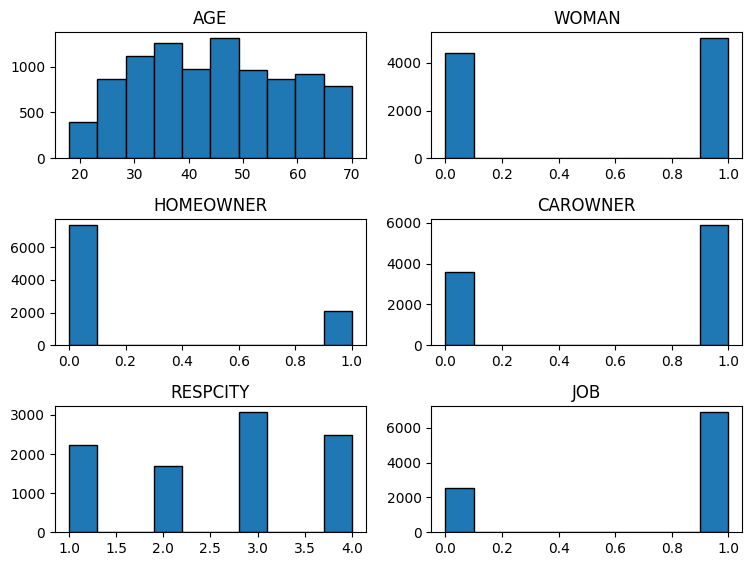

In [15]:
# Use pandas.hist() to plot the histogram of the relevant features
dff[sociovars_relevant].hist(edgecolor='black',grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

#### `Reflection`
Although we do not have **population statistics** readily available for the populations of the four cities, across the board, the sample looks good. At the very least, we do not see unexpected skews or imbalances <br>

### `2. The linear-additive RUM-MNL model` <br>

Now that we have developed a feeling for our data, we can start with estimating discrete choice models. For this, we will use the Python package called `Biogeme`. 


**`Biogeme database`**<br>
To use this package, we first need to create the data set as a Biogeme database object using `db.Database()`. This object contains the data in a format compatible with the library functions for model estimation in Biogeme.

In [16]:
# db.Database takes as arguments (1) a name (string) and (2) a data set (pandas dataframe)
biodata = db.Database('Neighboorhood_choice_data', dff)

**`Biogeme variables`**<br>

Also, we need to create Biogeme objects for all the variables in our data set that we want to use in our model specifications.<br>
The `Variable()` function creates an object that represents the variable values and will allow it to be included in the model estimation function.

In [17]:
# We create Variable objects for each of the variables in the data set that we want to use in the model

# Attributes of alternative 1
STORES1     = Variable('STORES1')
TRANSPORT1  = Variable('TRANSPORT1')
CITY1       = Variable('CITY1')
NOISE1      = Variable('NOISE1')
GREEN1      = Variable('GREEN1')
FOREIGN1    = Variable('FOREIGN1')

# Attributes of alternative 2    
STORES2     = Variable('STORES2')
TRANSPORT2  = Variable('TRANSPORT2')
CITY2       = Variable('CITY2')
NOISE2      = Variable('NOISE2')
GREEN2      = Variable('GREEN2')
FOREIGN2    = Variable('FOREIGN2')
    
# Attributes of alternative 3
STORES3     = Variable('STORES3')
TRANSPORT3  = Variable('TRANSPORT3')
CITY3       = Variable('CITY3')
NOISE3      = Variable('NOISE3')
GREEN3      = Variable('GREEN3')
FOREIGN3    = Variable('FOREIGN3')

# The choice
CHOICE      = Variable('CHOICE')

# Socio-economic variables
AGE         = Variable('AGE')
WOMAN       = Variable('WOMAN')
HOMEOWNER   = Variable('HOMEOWNER')
CAROWNER    = Variable('CAROWNER')
RESPCITY    = Variable('RESPCITY')
JOB         = Variable('JOB')

**`The linear-additive utility specification`**

We start with defining the utility specification of the model that we wish to estimate.<br>

For that, we must define the parameters to be estimated and specify the utility functions.<br>

In the linear-additive RUM-MNL model, the observed utility is *V* for alternative *i* is given by:

$V_i = \beta_1 \cdot \text{x}_{1i} + \beta_2 \cdot \text{x}_{2i} + \ldots + \beta_M \cdot \text{x}_{Mi}  $

Where:
- $\beta_1, \beta_2, \ldots, \beta_M$ denote the marginal utility associated with each attribute $m$.
- $\text{x}_{1i}, \text{x}_{2i}, \ldots, \text{x}_{Mi} $ correspond to the attribute values alternative *i*.

The cell below creates this utility function in Biogeme.

In [18]:
# Give a name to the model    
model_name = 'Linear-additive RUM-MNL'

# Define the model parameters, using the function "Beta()", in which you must define:
# the name of the parameter,
# starting value, 
# lower bound,
# upper bound, 
# 0 or 1, indicating if the parameter must be estimated. 0 means estimated, 1 means fixed to the starting value. 
B_stores    = Beta('B_stores'   , 0, None, None, 0)
B_transport = Beta('B_transport', 0, None, None, 0)
B_city      = Beta('B_city'     , 0, None, None, 0)
B_noise     = Beta('B_noise'    , 0, None, None, 0)
B_green     = Beta('B_green'    , 0, None, None, 0)
B_foreign   = Beta('B_foreign'  , 0, None, None, 0)

# Define the utility functions
V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise * NOISE1 + B_green * GREEN1 + B_foreign * FOREIGN1
V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise * NOISE2 + B_green * GREEN2 + B_foreign * FOREIGN2
V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise * NOISE3 + B_green * GREEN3 + B_foreign * FOREIGN3

**`Estimation function`** 

Now that we have specified the model, we need to estimate it. To do so, we create the following function `estimate_mnl` which we can re-use.

The estimation function takes the following inputs:
* Systematic utilities function (**V1, V2, V3**)
* Chosen alternatives array (**CHOICE**)
* Database which contains the relevant attributes and characteristics (**database**)
* Model name (**"string"**)


In [19]:
# This function estimates the MNL model and returns the estimation results
# input values: utilities for all three alternatives, the choices, the database, and the model name

def estimate_mnl(V1,V2,V3,CHOICE,database,name):
    
    # Create a dictionary to list the utility functions with the numbering of alternatives
    V = {1: V1, 2: V2, 3: V3}
        
    # Create a dictionary called av to describe the availability conditions of each alternative, where 1 indicates that the alternative is available, and 0 indicates that the alternative is not available.
    # This shows that all alternatives were available to all respondents. 
    av = {1: 1, 2: 1, 3: 1} 

    # Define the choice model: The function models.logit() computes the MNL choice probabilities of the chosen alternative given the V. 
    prob = models.logit(V, av, CHOICE)

    # Define the log-likelihood   
    LL = log(prob)
   
    # Create the Biogeme object containing the object database and the formula for the contribution to the log-likelihood of each row using the following syntax:
    biogeme = bio.BIOGEME(database, LL)
    
    # The following syntax passes the name of the model:
    biogeme.modelName = name

    # Some object settings regaridng whether to save the results and outputs 
    biogeme.generate_pickle = False
    biogeme.generate_html = False
    biogeme.saveIterations = False

    # Syntax to calculate the null log-likelihood. The null-log-likelihood is used to compute the rho-square 
    biogeme.calculateNullLoglikelihood(av)

    # This line starts the estimation and returns the results object.
    results = biogeme.estimate()
     
    return results

**`Estimation`**

We have created a biogeme database (biodata); we have defined our utility functions; and, we have created an estimation function to estimate MNL models (estimate_mnl).<br> 
Now, we only need to invoke the estimation by bringing these ingredients together. We pass the model specifications and the database to the estimation function. The function `estimate_mnl` returns an object which contains the estimation results.

In [20]:
# Estimate the model
results_MNL = estimate_mnl(V1,V2,V3,CHOICE,biodata,model_name)

**`View estimation results`**<br>

**Estimation statistics**

We can display a summary of the estimation statistics using `results.short_summary()` in which we see: 

* `Number of parameters`: Parameters being estimated.
* `Sample size`: The number of observations in the data set (used for estimating the model).
* `Excluded data`: The number of observations in the data set that were excluded for estimation.
* `Null log-likelihood`: The log-likelihood of the null model.
* `Final log-likelihood`: The log-likelihood of the estimated model.
* `Likelihood ratio test (null)`: A statistical test comparing the null model's likelihood with the likelihood of the estimated model. 
* `Rho square (null)`: Quantifies how well the model explains the data compared to the null model.
* `Rho bar square (null)`: Quantifies how well the model explains the data compared to the null model while penalising for the number of model parameters.
* `Akaike Information Criterion (AIC)`: A measure that shows the goodness of fit of the model, where lower AIC values indicate better models.
* `Bayesian Information Criterion (BIC)`: Similar to AIC, it penalizes model complexity more heavily, with lower values indicating better-fitting models while considering complexity.

**Parameter estimates**

We can display the estimated parameters using `results.getEstimatedParameters()`. Besides maximum likelihood estimates, we also see the associated standard errors, t-test values and p-values. The t-test values and p-values show the significance of the effect, demonstrating the generalisability of the relationship to the population.

In [21]:
# Print the estimation statistics
print(results_MNL.short_summary())

# Get the model parameters in a pandas table and  print it
beta_hat_MNL = results_MNL.getEstimatedParameters()
statistics_MNL = results_MNL.getGeneralStatistics()
print(beta_hat_MNL)

# Store the LL of the MNL model for later use
LL_MNL = results_MNL.data.logLike

Results for model Linear-additive RUM-MNL
Nbr of parameters:		6
Sample size:			9456
Excluded data:			0
Null log likelihood:		-10388.48
Final log likelihood:		-8403.772
Likelihood ratio test (null):		3969.412
Rho square (null):			0.191
Rho bar square (null):			0.19
Akaike Information Criterion:	16819.54
Bayesian Information Criterion:	16862.47

                Value  Rob. Std err  Rob. t-test  Rob. p-value
B_city      -0.167571      0.008076   -20.749441           0.0
B_foreign   -1.177581      0.109050   -10.798570           0.0
B_green      0.415726      0.011397    36.476251           0.0
B_noise     -0.438061      0.010593   -41.352803           0.0
B_stores    -0.034551      0.002587   -13.354178           0.0
B_transport -0.074348      0.002486   -29.911007           0.0


### `Exercise 2:  Interpreting modelling outcomes`<br>

Interpret the outcomes of your MNL model by answering the following questions:

`A` Did the model converge?<br>

`B` Are all estimated parameters of the expected sign?<br>

`C` Are they significant at the 5% level? <br>

`D` Based on the Likelihood Ratio Test: is the estimated model statistically superior to a  model that determines choices by ‘throwing a dice’? (i.e., the Null model).

`E` What would happen to the estimates and standard errors if you would have collected only half the amount of data? Verify your answer by testing it.

In [22]:
# Your code and answers

**`Attribute importance`**<br>

Next, we explore the importance of each attribute to the choice behaviour. To do so, we assess how much the model fit deteriorates when we fix one of the beta to zero. We do this for all six betas. A large drop in model fit indicates a great importance of attribute. After all, it means that without having access to that attribute, the model is less capable of explaining the choice behaviour.    

In [23]:
# Create a list with the parameter names
param_list = ['B_stores','B_transport','B_city','B_noise','B_green','B_foreign']

# Create an empty dataframe with the parameter names as index (rows) to store the results
df_out = pd.DataFrame(index = param_list + ['LL'])

# Loop over the parameters
for param_fix in param_list:
    
    model_name = f'linear-additive RUM-MNL with {param_fix} fixed to zero'
   
    # Parameters to be estimated
    # Note that int(param_fix == 'B_stores') returns 1 if param_fix is 'B_stores', and 0 otherwise
    B_stores    = Beta('B_stores'   , 0, None, None, int(param_fix == 'B_stores'))
    B_transport = Beta('B_transport', 0, None, None, int(param_fix == 'B_transport'))
    B_city      = Beta('B_city'     , 0, None, None, int(param_fix == 'B_city'))
    B_noise     = Beta('B_noise'    , 0, None, None, int(param_fix == 'B_noise'))
    B_green     = Beta('B_green'    , 0, None, None, int(param_fix == 'B_green'))
    B_foreign   = Beta('B_foreign'  , 0, None, None, int(param_fix == 'B_foreign'))
    
    # Definition of the utility functions
    V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise * NOISE1 + B_green * GREEN1 + B_foreign * FOREIGN1
    V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise * NOISE2 + B_green * GREEN2 + B_foreign * FOREIGN2
    V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise * NOISE3 + B_green * GREEN3 + B_foreign * FOREIGN3

    # Estimate the model
    results = estimate_mnl(V1,V2,V3,CHOICE,biodata,model_name)

    # Store the parameter estimates in a dataframe
    col = param_fix + '_fixed'
    df_out.loc[:,col] = results.getBetaValues()

    # Store the log-likelihood
    df_out.loc['LL',col] = results.getGeneralStatistics()['Final log likelihood'][0]

# Show the dataframe with the results
df_out

,B_stores_fixed,B_transport_fixed,B_city_fixed,B_noise_fixed,B_green_fixed,B_foreign_fixed
B_stores,NaN,-0.028203,-0.028614,-0.025019,-0.029281,-0.034871
B_transport,-0.071676,NaN,-0.065899,-0.066888,-0.069872,-0.072504
B_city,-0.155785,-0.131766,NaN,-0.118049,-0.138288,-0.166845
B_noise,-0.425138,-0.413315,-0.402299,NaN,-0.407513,-0.436077
B_green,0.410422,0.387239,0.395589,0.370064,NaN,0.417203
B_foreign,-1.187867,-1.006801,-1.152465,-1.038864,-1.223824,NaN
LL,-8493.676725,-8851.472218,-8628.140632,-9212.649391,-9092.802681,-8460.605901


### `Exercise 3: Attribute importance`<br>

`A` List the attributes from most important to least important, based on their impact on the model fit.

`B` Use the Likelihood Ratio Statistic (LRS) to test, for each of the six models, whether the restricted model is statistically preferred over the unrestricted model (i.e. the linear-additive RUM-MNL model with LL = -8403.772 and 6 parameters).<br>
<br>
The LRS is given by: <br>
<br>
$LRS = -2 \left[LL(\beta_R)-LL(\beta_U)\right] $<br>
<br>
Where $\beta_R$ and $\beta_U$ correspond to the parameters estimated using a restricted and unrestricted model, respectively.<br>

You need to compare the LRS with the critical $\chi^2$ value associated with a specific significance level. If $LRS > \chi^2_{df}$ , you can conclude that the unrestricted model better explains the data than the restricted model.<br>

Use α = 0.01 as the critical threshold level of significance. The [Chi-Square Distribution Table](https://github.com/SEN1221TUD/2023_internal/blob/main/lab_session_1/data/Chi-Square%20Distribution%20Table.pdf), can be found here.<br>

In [24]:
# Your code and answers

### `3. Interactions with socio-demographic variables and nonlinear utilities`<br>

**`Interactions with socio-demographic variables`**<br>

Preferences and tastes may vary across socio-demographic segments of the population. By interacting socio-demographic variables with the other attributes, we can obtain insights into how preferences vary across socio-demographic groups.<br>

For example, we can include the variable `WOMAN` as an interaction with one of the attributes, e.g. `FOREIGN`. This allows us to analyse whether there is a difference between males and females in terms of their taste over this attribute. <br>

To specify a model with interactions, we create separate taste parameters for `WOMAN` and for `MAN`, to interact with the attribute `FOREIGN`: <br>

                    B_foreign_woman = Beta('B_foreign_woman'  , 0, None, None, 0)
                    B_foreign_man   = Beta('B_foreign_man'    , 0, None, None, 0)

                    V1 =  ... + (B_foreign_man * (WOMAN == 0) + B_woman_foreign_woman * (WOMAN == 1)) * FOREIGN1

In [25]:
# Give a name to the model   
model_name = 'Linear-additive RUM-MNL with interaction term'

B_stores        = Beta('B_stores'       , 0, None, None, 0)
B_transport     = Beta('B_transport'    , 0, None, None, 0)
B_city          = Beta('B_city'         , 0, None, None, 0)
B_noise         = Beta('B_noise'        , 0, None, None, 0)
B_green         = Beta('B_green'        , 0, None, None, 0)
B_foreign_man   = Beta('B_foreign_man'  , 0, None, None, 0)
B_foreign_woman = Beta('B_foreign_woman', 0, None, None, 0)

# Definition of the utility functions
V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise * NOISE1 + B_green * GREEN1 + (B_foreign_man*(WOMAN==0) + B_foreign_woman*(WOMAN==1)) * FOREIGN1
V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise * NOISE2 + B_green * GREEN2 + (B_foreign_man*(WOMAN==0) + B_foreign_woman*(WOMAN==1)) * FOREIGN2
V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise * NOISE3 + B_green * GREEN3 + (B_foreign_man*(WOMAN==0) + B_foreign_woman*(WOMAN==1)) * FOREIGN3

# Estimate the model using the estimate_mnl function created before
results_interaction = estimate_mnl(V1,V2,V3,CHOICE,biodata,model_name)

# Print the estimation statistics
print(results_interaction.short_summary())

# Get the model parameters in a pandas table and then print it
beta_hat_interaction = results_interaction.getEstimatedParameters()
print(beta_hat_interaction)


Results for model Linear-additive RUM-MNL with interaction term
Nbr of parameters:		7
Sample size:			9456
Excluded data:			0
Null log likelihood:		-10388.48
Final log likelihood:		-8399.519
Likelihood ratio test (null):		3977.917
Rho square (null):			0.191
Rho bar square (null):			0.191
Akaike Information Criterion:	16813.04
Bayesian Information Criterion:	16863.12

                    Value  Rob. Std err  Rob. t-test  Rob. p-value
B_city          -0.167538      0.008077   -20.742906  0.000000e+00
B_foreign_man   -1.522909      0.163102    -9.337182  0.000000e+00
B_foreign_woman -0.876878      0.146795    -5.973479  2.322474e-09
B_green          0.415810      0.011399    36.479316  0.000000e+00
B_noise         -0.438447      0.010595   -41.380782  0.000000e+00
B_stores        -0.034471      0.002587   -13.325367  0.000000e+00
B_transport     -0.074408      0.002486   -29.932191  0.000000e+00


In general, the coefficient `B_foreign` represents the marginal utility of the percentage of foreigners in a neighbourhood. Since the estimated coefficient is negative, it means that an increase in the percentage of foreigners in a neighbourhood makes it less attractive.  In this model, we have interacted `gender` with the attribute `FOREIGN`. The parameters `B_foreign_woman` and `B_foreign_man` show that man and woman have different tastes over this attribute. Since the estimated coefficient is much smaller for woman it indicates that woman place less value on the share of foreigners in a neighbourhood than men. 

### `Excersice 4: Modelling interactions with socio-demographic variables`

Perhaps inhabitants in different cities have different tastes over the share of foreigners. To investigate this, you need to estimate another model with interactions. This time you interact variable `RESPECITY` with `FOREIGN`. Note that RESPCITY has 4 categorical levels.

Interpret your results. <br>

`A` Do you find evidence of taste heterogeneity? I.e. do inhabitants of different cities have different tastes over the share of foreigners?<br>

`B` Use the LRS to determine whether the model with interactions outperforms the linear-additive RUM-MNL model without interactions.

In [26]:
# Your code and answers

**`Nonlinear utility specifications`** 

Until now, we have assumed in our utility specification that utility is linear (and additive). This means that the change in utility caused by a unit change in the attribute level is independent of attribute's base level. We are to going assess the validity of this assumption by testing the alternative hypothesis, i.e. utility is nonlinear.<br>

More specifically, we test the assumption that the utility derived from distance to the grocery store (`STORES`) takes a logarithmic form:

$ V_{i} = \beta_{stores}\ln(STORES) + ...$

Because the logarithm is a globally concave function, this assumption implies that the disutility of e.g. a 10-minutes trip is less than the disutility of two trips of 5 minutes.

In [27]:
# Give a name to the model  
model_name = 'MNL with non-linearities'

# Parameters to be estimated
B_stores    = Beta('B_stores'   , 0, None, None, 0)
B_transport = Beta('B_transport', 0, None, None, 0)
B_city      = Beta('B_city'     , 0, None, None, 0)
B_noise     = Beta('B_noise'    , 0, None, None, 0)
B_green     = Beta('B_green'    , 0, None, None, 0)
B_foreign   = Beta('B_foreign'  , 0, None, None, 0) 
B_noise_2    = Beta('B_noise_2'    , 0, None, None, 1)   

# Definition of the utility functions
V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise_2 * NOISE1**2 + B_noise * NOISE1 + B_green * GREEN1 + B_foreign * FOREIGN1
V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise_2 * NOISE2**2 + B_noise * NOISE2 + B_green * GREEN2 + B_foreign * FOREIGN2
V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise_2 * NOISE3**2 + B_noise * NOISE3 + B_green * GREEN3 + B_foreign * FOREIGN3

# Estimate
results_nonlin = estimate_mnl(V1,V2,V3,CHOICE,biodata,model_name)   

# Print the estimation statistics
print(results_nonlin.short_summary())

# Get the model parameters in a pandas table and then print it
beta_hat_nonlin = results_nonlin.getEstimatedParameters()
print(beta_hat_nonlin)

Results for model MNL with non-linearities
Nbr of parameters:		6
Sample size:			9456
Excluded data:			0
Null log likelihood:		-10388.48
Final log likelihood:		-8403.772
Likelihood ratio test (null):		3969.412
Rho square (null):			0.191
Rho bar square (null):			0.19
Akaike Information Criterion:	16819.54
Bayesian Information Criterion:	16862.47

                Value  Rob. Std err  Rob. t-test  Rob. p-value
B_city      -0.167571      0.008076   -20.749441           0.0
B_foreign   -1.177581      0.109050   -10.798570           0.0
B_green      0.415726      0.011397    36.476251           0.0
B_noise     -0.438061      0.010593   -41.352803           0.0
B_stores    -0.034551      0.002587   -13.354178           0.0
B_transport -0.074348      0.002486   -29.911007           0.0


The results show that the model fit deteriorated because of the nonlinearity. Hence, we keep our assumption that utility is linear with `STORES`.

### `Exercise 5: Nonlinear utility specifications`

Now, let's turn our attention to the attribute `NOISE`. With noise, we expect the opposite effect of diminishing marginal utility. That is, the utility derived from "high" traffic noise (level 4) is probably much worse than that of two times "little" traffic noise (level 2). To investigate this, you need to estimate two nonlinear models, in which you try:

(1) $ V_i = ... + \beta_{noise} \cdot exp(STORES) + ... $

(2) $ V_i = ... + \beta_{noise} \cdot STORES + \beta_{noise^2} \cdot STORES^2 + ...   $

Interpret your results. <br>

`A` Do you find evidence of nonlinear utility? <br>

`B` Which of the two models is statistically the best model?

In [28]:
# Your code and answers

### `4. Market share forecasting for Zurich`

Suppose the municipality of Zurich plans to redevelop one of their least accessible neighbourhoods in the North: `Affoltern, Oerlikon, Seebach` (11). Figure 1 shows the neighbourhoods of Zurich. The municipality plans to develop a new shopping area and public transport hub in the neighbourhood. The idea is that this will make the neighbourhood more attractive to live in. But, these plans are costly. Therefore, to make an informed decision, the municipality needs to have a good understanding of the impact of increasing the accessibility in `Affoltern, Oerlikon, Seebach` on the residential demand in that neighbourhood. <br>

The **current** situation - in terms of the attributes we have looked at in this study - is shown in the table below.<br>
**After** the redevelopment, the average distance to grocery stores and public transport is 5 minutes (STORES = 5, TRANSPORT = 5) instead of 15 minutes.


| neighbourhood name                        | ID         | CITY    | FOREIGN  | GREEN  | NOISE  | STORES   | TRANSPORT  |
|-------------------------------------------|------------|---------|----------|--------|--------|----------|------------|
| Altstadt                                  | 1          | 1       | 0.22     | 2      | 1      | 2        | 5          |
| Enge, Wollishofen, Leimbach               | 2          | 4       | 0.16     | 4      | 3      | 5        | 10         |
| Wiedikon                                  | 3          | 3       | 0.23     | 3      | 3      | 10       | 15         |
| Aussersihl                                | 4          | 2       | 0.27     | 1      | 4      | 5        | 5          |
| Industriequartier                         | 5          | 2       | 0.18     | 1      | 4      | 10       | 2          |
| Oberstrass, Unterstrass                   | 6          | 3       | 0.16     | 3      | 3      | 10       | 10         |
| Fluntern, Hottingen, Hirslanden, Witikon  | 7          | 4       | 0.16     | 4      | 1      | 10       | 15         |
| Riesbach                                  | 8          | 3       | 0.18     | 3      | 3      | 5        | 15         |
| Altstetten, Albisrieden                   | 9          | 4       | 0.31     | 3      | 2      | 5        | 10         |
| Wipkingen, Höngg                          | 10         | 4       | 0.25     | 4      | 3      | 15       | 10         |
| Affoltern, Oerlikon, Seebach              | 11         | 4       | 0.33     | 3      | 3      | 15       | 15         |
| Schwamendingen                            | 12         | 4       | 0.36     | 4      | 3      | 5        | 10         |

![Zurich](data/zurich.png)

To inform this policy decision, we will use our estimated choice models. To do so, we take the following steps:
1. We use our estimated MNL model to compute the choice probabilities of the neighbourhoods for the **current situation**
2. We use our estimated MNL model to compute the choice probabilities of the neighbourhoods for the **future situation**
3. We compare the probabilities between the present and future.

In [29]:
# Load the data as a pandas dataframe
data_path =  Path(f'data/zurich_data.csv')
df_zurich = pd.read_csv(data_path, index_col=0)

# Show the the dataframe
df_zurich

,ID,CITY,FOREIGN,GREEN,NOISE,STORES,TRANSPORT
Neighbourhood,,,,,,,
Altstadt,1,1,0.2222,2,1,2,5
"Enge, Wollishofen, Leimbach",2,4,0.1572,4,3,5,10
Wiedikon,3,3,0.2345,3,3,10,15
Aussersihl,4,2,0.2734,1,4,5,5
Industriequartier,5,2,0.1806,1,4,10,2
"Oberstrass, Unterstrass",6,3,0.1588,3,3,10,10
"Fluntern, Hottingen, Hirslanden, Witikon",7,4,0.1600,4,1,10,15
Riesbach,8,3,0.1798,3,3,5,15
"Altstetten, Albisrieden",9,4,0.3077,3,2,5,10


In [30]:
# Manually compute the utilities for each neighbourhood alternative in the present situation
# Let's use our benchmark linear-additive MNL model
V_zurich_present =  (beta_hat_MNL['Value']['B_city']      * df_zurich['CITY'] +
                     beta_hat_MNL['Value']['B_foreign']   * df_zurich['FOREIGN'] + 
                     beta_hat_MNL['Value']['B_green']     * df_zurich['GREEN'] + 
                     beta_hat_MNL['Value']['B_noise']     * df_zurich['NOISE'] + 
                     beta_hat_MNL['Value']['B_stores']    * df_zurich['STORES'] + 
                     beta_hat_MNL['Value']['B_transport'] * df_zurich['TRANSPORT'])

# Compute the market shares using the logit formula: Pi = exp(Vi)/sum(exp(Vj)) 
P_present = np.exp(V_zurich_present)/np.sum(np.exp(V_zurich_present))

In [31]:
# Manually compute the market shares for each neighbourhood alternative in the future scenario

# Create a copy of the dataframe, and change the accessibility of stores and transport
df_zurich_future = df_zurich.copy()
df_zurich_future.loc['Affoltern, Oerlikon, Seebach','STORES'] = 5
df_zurich_future.loc['Affoltern, Oerlikon, Seebach','TRANSPORT'] = 5

# Manually compute the utilities for each neighbourhood alternative in the future situation
V_zurich_future = (beta_hat_MNL['Value']['B_city']      * df_zurich_future['CITY'] +
                   beta_hat_MNL['Value']['B_foreign']   * df_zurich_future['FOREIGN'] + 
                   beta_hat_MNL['Value']['B_green']     * df_zurich_future['GREEN'] + 
                   beta_hat_MNL['Value']['B_noise']     * df_zurich_future['NOISE'] + 
                   beta_hat_MNL['Value']['B_stores']    * df_zurich_future['STORES'] + 
                   beta_hat_MNL['Value']['B_transport'] * df_zurich_future['TRANSPORT'])

# Compute the market shares using the logit formula
P_future = np.exp(V_zurich_future)/np.sum(np.exp(V_zurich_future))

In [32]:
# Create a dataframe with the market shares in the present and future scenarios
df_zurich_marketshares = pd.DataFrame({'Present [%]': P_present*100, 'Future [%]': P_future*100})

# Show the dataframe
df_zurich_marketshares.round(2)

,Present [%],Future [%]
Neighbourhood,,
Altstadt,25.29,22.54
"Enge, Wollishofen, Leimbach",9.82,8.75
Wiedikon,4.06,3.62
Aussersihl,3.22,2.87
Industriequartier,3.78,3.36
"Oberstrass, Unterstrass",6.43,5.73
"Fluntern, Hottingen, Hirslanden, Witikon",13.63,12.15
Riesbach,5.14,4.58
"Altstetten, Albisrieden",8.41,7.49


The table shows that the market share of `Affoltern, Oerlikon, Seebach` increases substantially: it more than doubles.<br> Hence, the model suggests that increasing accessibility will make the neighbourhood considerably more attractive. 


### `Exercise 6: Forecasting`

`A` Determine which neighbourhoods lose the most market share in (a) absolute and (b) relative terms.<br>

`B` Reflect on the behavioural realism of your results, especially w.r.t. the relative changes in market shares. <br>

`C` From the modelling perspective, explain why the equal relative changes in market shares were to be expected. Use the notion of "IIA" in your answers.<br>

`D` Currently, `Affoltern, Oerlikon, Seebach` is a quiet urban area. The creation of a public transport hub there will likely increase the average noise levels. Our earlier analysis showed that noise is an important factor in the residential location choice. Therefore, a change in noise levels needs also to be taken into account. <br>

* Create a plot showing how increasing noise for 1 to 4 leads to a deterioration of the market share of `Affoltern, Oerlikon, Seebach`. Thus, the *x*-axis shows the noise level, and the *y*-axis the market share.<br>

* Based on your results, what would you recommend to the planners of Zurich?

In [45]:
# Your code and answers


## END